In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
img_size = 256 
Batch_size = 32
epochs = 50
rgb_channel = 3

# Stage 1 : Data Collection

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato-Leaf-Data",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
print(f"Total Batches in our dataset:{len(dataset)}\nThe total images are:{len(dataset)*Batch_size}")

Total Batches in our dataset:68
The total images are:2176


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 2 0 0 0 1 0 2 2 0 2 1 0 0 0]


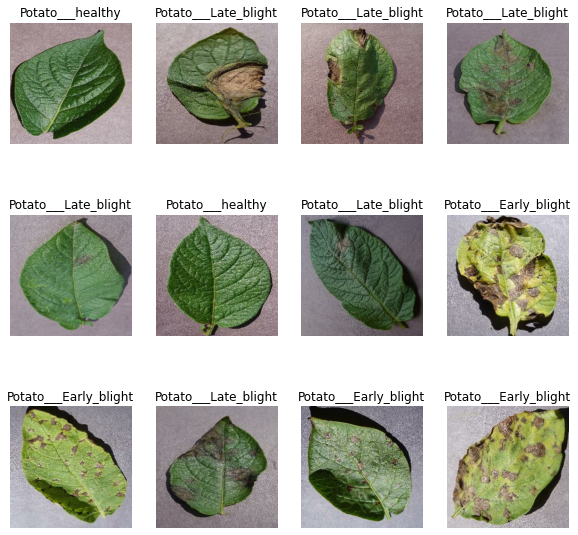

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #3 ROW 4 COLUMN and i+1th plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Stage 2 : Data Preprocessing

In [9]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split=0.1,val_split=0.1,shuffle = True,shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=10)
    
    ds_size = len(ds)
    train_size=int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Stage 3: Model Building

In [15]:
input_shape = (Batch_size, img_size, img_size, rgb_channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 137s 2s/step - loss: 0.9294 - accuracy: 0.4842 - val_loss: 0.8975 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 105s 2s/step - loss: 0.8391 - accuracy: 0.5329 - val_loss: 0.6988 - val_accuracy: 0.6458
Epoch 3/50
54/54 [==============================] - 89s 2s/step - loss: 0.6570 - accuracy: 0.6931 - val_loss: 0.4798 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 91s 2s/step - loss: 0.5348 - accuracy: 0.7617 - val_loss: 0.6303 - val_accuracy: 0.7552
Epoch 5/50
54/54 [==============================] - 86s 2s/step - loss: 0.3844 - accuracy: 0.8498 - val_loss: 0.3008 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.2442 - accuracy: 0.9038 - val_loss: 0.4352 - val_accuracy: 0.8385
Epoch 7/50
54/54 [==============================] - 91s 2s/step - loss: 0.1785 - accuracy: 0.9331 - val_loss: 0.9654 - val_accuracy: 0.7240
Epoch 8/50
54/54 [

# Stage:4 MODELTesting and Evaluation

In [29]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 286ms/step - loss: 0.1249 - accuracy: 0.9688


[0.12487272918224335, 0.96875]

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

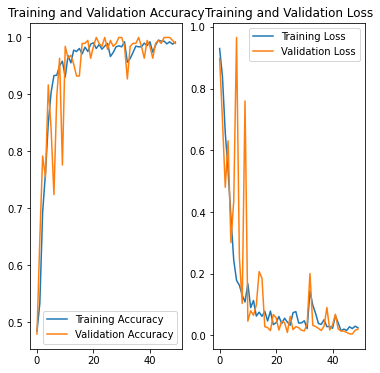

In [31]:
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


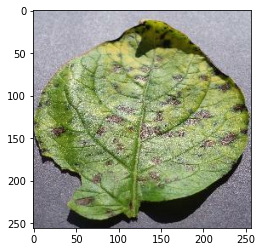

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

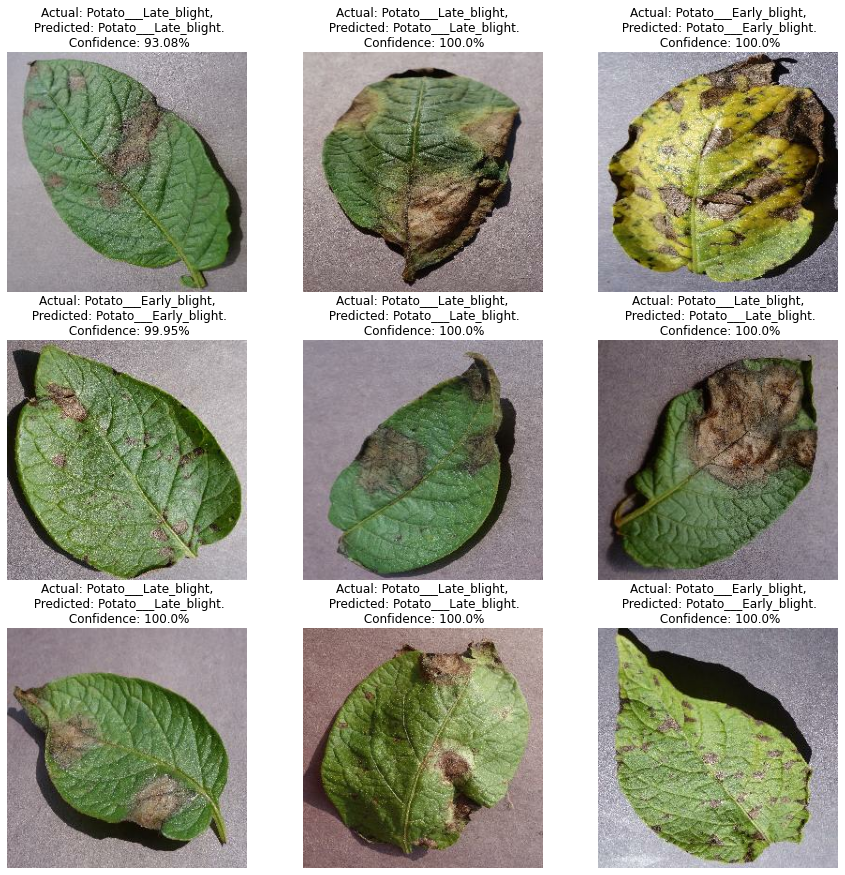

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
model.save('./models', save_format='tf') 

INFO:tensorflow:Assets written to: ./models\assets
